In [99]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
import pandas as pd
from pathlib import Path
import json
import yaml
import cv2
from PIL import Image
from collections import defaultdict
import random

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [100]:
class EvaluationConfig:
    def __init__(self):
        # Paths
        self.DATA_ROOT = Path("../data")
        self.DATA_YAML = "../data/data.yaml"
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.NUM_CLASSES = 13  # AgroPest-12 has 12 classes + background
        
        # Evaluation settings
        self.CONFIDENCE_THRESHOLDS = np.arange(0.0, 0.1, 0.005)
        self.IOU_THRESHOLD = 0.1
        self.RESULTS_DIR = Path("../results/faster_rcnn_evaluation")

config = EvaluationConfig()

# Load class names to match your actual data
class_names = ['background', 'Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']

print(f"📊 Classes ({len(class_names)-1}): {class_names[1:]}")
print(f"📁 Results will be saved to: {config.RESULTS_DIR}")

📊 Classes (12): ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']
📁 Results will be saved to: ..\results\faster_rcnn_evaluation


In [101]:
# =============================================================================
# MODEL LOADING
# =============================================================================

def load_trained_model():
    """Load the trained Faster R-CNN model"""
    
    # Create model architecture
    model = fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, config.NUM_CLASSES)
    
    # Load trained weights
    checkpoint = torch.load('faster_rcnn_checkpoint_epoch_5.pth', map_location=config.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(config.DEVICE)
    model.eval()
    
    print(f"✅ Model loaded from epoch {checkpoint.get('epoch', 'Unknown')}")
    print(f"📈 Training loss: {checkpoint.get('train_loss', 'Unknown'):.4f}")
    print(f"📉 Validation loss: {checkpoint.get('valid_loss', 'Unknown'):.4f}")
    
    return model

# Load the model
trained_model = load_trained_model()

✅ Model loaded from epoch 5
📈 Training loss: 0.1608
📉 Validation loss: 0.1304


In [102]:
# =============================================================================
# GROUND TRUTH LOADING
# =============================================================================

def load_ground_truth_annotations():
    """Load ground truth annotations from test set"""
    
    test_labels_dir = config.DATA_ROOT / 'test' / 'labels'
    test_images_dir = config.DATA_ROOT / 'test' / 'images'
    
    annotations = {}
    
    print("📂 Loading ground truth annotations...")
    
    for label_file in test_labels_dir.glob('*.txt'):
        img_name = label_file.stem
        
        # Find corresponding image
        img_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            potential_path = test_images_dir / f"{img_name}{ext}"
            if potential_path.exists():
                img_path = potential_path
                break
        
        if img_path is None:
            continue
            
        # Load image dimensions
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # Parse YOLO format annotations
        boxes = []
        labels = []
        
        try:
            with open(label_file, 'r') as f:
                lines = [line.strip() for line in f if line.strip()]
            
            for line in lines:
                parts = line.split()
                if len(parts) >= 5:
                    class_id = int(parts[0]) + 1  # Convert to 1-indexed
                    center_x = float(parts[1]) * img_width
                    center_y = float(parts[2]) * img_height
                    width = float(parts[3]) * img_width
                    height = float(parts[4]) * img_height
                    
                    # Convert to [x1, y1, x2, y2]
                    x1 = center_x - width / 2
                    y1 = center_y - height / 2
                    x2 = center_x + width / 2
                    y2 = center_y + height / 2
                    
                    boxes.append([x1, y1, x2, y2])
                    labels.append(class_id)
        except:
            continue
        
        if len(boxes) > 0:
            annotations[str(img_path)] = {
                'boxes': np.array(boxes),
                'labels': np.array(labels)
            }
    
    print(f"✅ Loaded {len(annotations)} test images with annotations")
    return annotations

# Load ground truth
gt_annotations = load_ground_truth_annotations()

📂 Loading ground truth annotations...
✅ Loaded 546 test images with annotations


In [104]:
# =============================================================================
# MODEL EVALUATION ON TEST SET
# =============================================================================

def evaluate_model():
    """Run model on test set and collect predictions"""
    
    print("🔍 Running model evaluation on test set...")
    
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    all_predictions = []
    
    for i, (img_path, gt_data) in enumerate(gt_annotations.items()):
        if i % 50 == 0:
            print(f"  Processing {i+1}/{len(gt_annotations)}")
        
        try:
            # Load and preprocess image
            image = Image.open(img_path).convert('RGB')
            original_size = image.size
            input_tensor = transform(image).unsqueeze(0).to(config.DEVICE)
            
            # Run inference
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            
            pred = predictions[0]
            pred_boxes = pred['boxes'].cpu().numpy()
            pred_scores = pred['scores'].cpu().numpy()
            pred_labels = pred['labels'].cpu().numpy()
            
            # Scale boxes back to original size
            if len(pred_boxes) > 0:
                scale_x = original_size[0] / 640
                scale_y = original_size[1] / 640
                pred_boxes[:, [0, 2]] *= scale_x
                pred_boxes[:, [1, 3]] *= scale_y
            
            # Store predictions
            for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                all_predictions.append({
                    'image': img_path,
                    'box': box,
                    'score': score,
                    'label': label
                })
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    print(f"✅ Evaluation complete: {len(all_predictions)} total predictions")
    return all_predictions

# Run evaluation
predictions = evaluate_model()

🔍 Running model evaluation on test set...
  Processing 1/546
  Processing 51/546
  Processing 101/546
  Processing 151/546
  Processing 201/546
  Processing 251/546
  Processing 301/546
  Processing 351/546
  Processing 401/546
  Processing 451/546
  Processing 501/546
✅ Evaluation complete: 3448 total predictions


In [105]:
# =============================================================================
# CALCULATE EVALUATION METRICS
# =============================================================================

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

def calculate_metrics_at_confidence(conf_threshold=0.05):
    """Calculate precision, recall, F1 for each class at given confidence"""
    
    print(f"🔍 Debugging evaluation at confidence {conf_threshold}")
    
    metrics = {}
    total_predictions_made = 0
    total_matches_found = 0
    
    for class_idx in range(1, len(class_names)):  # Skip background
        class_name = class_names[class_idx]
        
        # Filter predictions by class and confidence
        class_preds = [p for p in predictions 
                      if p['label'] == class_idx and p['score'] >= conf_threshold]
        
        # Get ground truth for this class
        class_gt = []
        for img_path, gt_data in gt_annotations.items():
            for box, label in zip(gt_data['boxes'], gt_data['labels']):
                if label == class_idx:
                    class_gt.append({'image': img_path, 'box': box, 'label': label})
        
        total_predictions_made += len(class_preds)
        
        # DEBUG: Show what we're working with
        if len(class_preds) > 0 or len(class_gt) > 0:
            print(f"\n📊 {class_name} (class_idx={class_idx}):")
            print(f"  Predictions above {conf_threshold}: {len(class_preds)}")
            print(f"  Ground truth objects: {len(class_gt)}")
            
            # Show first few predictions
            if len(class_preds) > 0:
                print(f"  Sample prediction scores: {[p['score'] for p in class_preds[:3]]}")
        
        # Calculate matches (your existing logic)
        tp = 0
        fp = 0
        fn = 0
        
        image_groups = defaultdict(lambda: {'pred': [], 'gt': []})
        
        for pred in class_preds:
            image_groups[pred['image']]['pred'].append(pred)
        
        for gt in class_gt:
            image_groups[gt['image']]['gt'].append(gt)
        
        matches_for_class = 0
        for img_path, data in image_groups.items():
            pred_boxes = [p['box'] for p in data['pred']]
            gt_boxes = [g['box'] for g in data['gt']]
            
            matched_gt = set()
            
            for pred_box in pred_boxes:
                best_iou = 0
                best_gt_idx = -1
                
                for gt_idx, gt_box in enumerate(gt_boxes):
                    if gt_idx in matched_gt:
                        continue
                    
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx
                
                if best_iou >= config.IOU_THRESHOLD:
                    tp += 1
                    matched_gt.add(best_gt_idx)
                    matches_for_class += 1
                else:
                    fp += 1
                    # DEBUG: Show why it failed
                    if best_iou > 0:
                        print(f"    ❌ Failed match: IoU {best_iou:.3f} < threshold {config.IOU_THRESHOLD}")
            
            fn += len(gt_boxes) - len(matched_gt)
        
        total_matches_found += matches_for_class
        
        # Calculate metrics (rest of your existing code)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn
        }
    
    print(f"\n📈 Overall Debug Summary:")
    print(f"  Total predictions made: {total_predictions_made}")
    print(f"  Total matches found: {total_matches_found}")
    print(f"  Match rate: {total_matches_found/total_predictions_made*100:.1f}%" if total_predictions_made > 0 else "  No predictions made")
    
    return metrics

# Calculate metrics at 0.5 confidence
metrics_05 = calculate_metrics_at_confidence(0.05)
print(f"📊 Metrics calculated at confidence = {metrics_05}")

🔍 Debugging evaluation at confidence 0.05

📊 Ants (class_idx=1):
  Predictions above 0.05: 633
  Ground truth objects: 87
  Sample prediction scores: [np.float32(0.0988497), np.float32(0.06428306), np.float32(0.08364434)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.097 < threshold 0.1
    ❌ Failed match: IoU 0.084 < threshold 0.1
    ❌ Failed match: IoU 0.048 < threshold 0.1
    ❌ Failed match: IoU 0.022 < threshold 0.1
    ❌ Failed match: IoU 0.051 < threshold 0.1
    ❌ Failed match: IoU 0.000 < threshold 0.1
    ❌ Failed match: IoU 0.009 < threshold 0.1

📊 Bees (class_idx=2):
  Predictions above 0.05: 500
  Ground truth objects: 44
  Sample prediction scores: [np.float32(0.1092026), np.float32(0.076264344), np.float32(0.09526324)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.054 < threshold 0.1
    ❌ Failed match: IoU 0.093 < threshold 0.1

📊 Beetles (class_idx=3):
  Predictions above 0.05: 237
  Ground truth objects: 44
  Sample

In [106]:
# =============================================================================
# CONFIDENCE ANALYSIS - SEE WHAT MODEL PREDICTS (FIXED)
# =============================================================================
def analyze_model_confidence():
    """Check what confidence scores the model actually produces"""
    
    print("🔍 Analyzing model predictions across ALL classes...")
    
    # Get test images
    test_images_dir = config.DATA_ROOT / 'test' / 'images' 
    all_images = list(test_images_dir.glob('*.jpg'))
    
    # Sample images from different classes
    class_samples = {}
    for img_path in all_images:
        # Extract class from filename (first part before '-')
        class_prefix = img_path.name.split('-')[0]
        if class_prefix not in class_samples:
            class_samples[class_prefix] = []
        class_samples[class_prefix].append(img_path)
    
    # Take 2 images from each class
    sample_images = []
    for class_name, images in class_samples.items():
        sample_images.extend(images[:2])  # 2 per class
    
    print(f"📊 Testing {len(sample_images)} images from {len(class_samples)} classes")
    print(f"Classes found: {list(class_samples.keys())}")
    
    all_scores = []
    class_detections = {}  # Track detections per class
    
    for img_path in sample_images:
        image = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((416, 416)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(image).unsqueeze(0).to(config.DEVICE)
        
        with torch.no_grad():
            pred = trained_model(input_tensor)[0]
        
        scores = pred['scores'].cpu().numpy()
        labels = pred['labels'].cpu().numpy()
        
        # Track which classes are being predicted
        for label in labels:
            if label < len(class_names):
                predicted_class = class_names[label]
                if predicted_class not in class_detections:
                    class_detections[predicted_class] = 0
                class_detections[predicted_class] += 1
        
        print(f"\n📊 {img_path.name}:")
        print(f"  Total detections: {len(scores)}")
        if len(scores) > 0:
            print(f"  Score range: {scores.min():.3f} - {scores.max():.3f}")
            print(f"  Above 0.05: {sum(scores > 0.05)}")  # Added lower threshold
            print(f"  Above 0.1: {sum(scores > 0.1)}")
            print(f"  Above 0.3: {sum(scores > 0.3)}")
            print(f"  Above 0.5: {sum(scores > 0.5)}")
            
            # Show top predictions
            top_indices = np.argsort(scores)[-3:][::-1]
            for idx in top_indices:
                class_name = class_names[labels[idx]]
                print(f"    {class_name}: {scores[idx]:.3f}")
        
        all_scores.extend(scores)
    
    if len(all_scores) > 0:
        print(f"\n📈 Overall Analysis:")
        print(f"  Average confidence: {np.mean(all_scores):.3f}")
        print(f"  Max confidence: {np.max(all_scores):.3f}")
        print(f"  Recommended threshold: {np.percentile(all_scores, 80):.3f}")
        
        print(f"\n📋 Classes Being Predicted:")
        for class_name, count in sorted(class_detections.items()):
            print(f"  {class_name}: {count} detections")
    
    return all_scores

# Run analysis
confidence_scores = analyze_model_confidence()

🔍 Analyzing model predictions across ALL classes...
📊 Testing 24 images from 12 classes
Classes found: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'Weevil']

📊 ants-112-_jpg.rf.b8d6b9acf9fa1edfb438381cbae99199.jpg:
  Total detections: 18
  Score range: 0.056 - 0.119
  Above 0.05: 18
  Above 0.1: 2
  Above 0.3: 0
  Above 0.5: 0
    Bees: 0.119
    Ants: 0.101
    Snails: 0.080

📊 ants-122-_jpg.rf.4819e9d7a1531a8b3a430c66b0c4c4bf.jpg:
  Total detections: 17
  Score range: 0.058 - 0.119
  Above 0.05: 17
  Above 0.1: 1
  Above 0.3: 0
  Above 0.5: 0
    Snails: 0.119
    Bees: 0.093
    Ants: 0.079

📊 bees-10-_jpg.rf.fbdce3be3d965219325984c83a2a1169.jpg:
  Total detections: 3
  Score range: 0.061 - 0.173
  Above 0.05: 3
  Above 0.1: 1
  Above 0.3: 0
  Above 0.5: 0
    Bees: 0.173
    Ants: 0.084
    Bees: 0.061

📊 bees-112-_jpg.rf.24609662f0f1e1507afa138449713d73.jpg:
  Total detections: 1
  Score range: 0.069 - 0.069
  

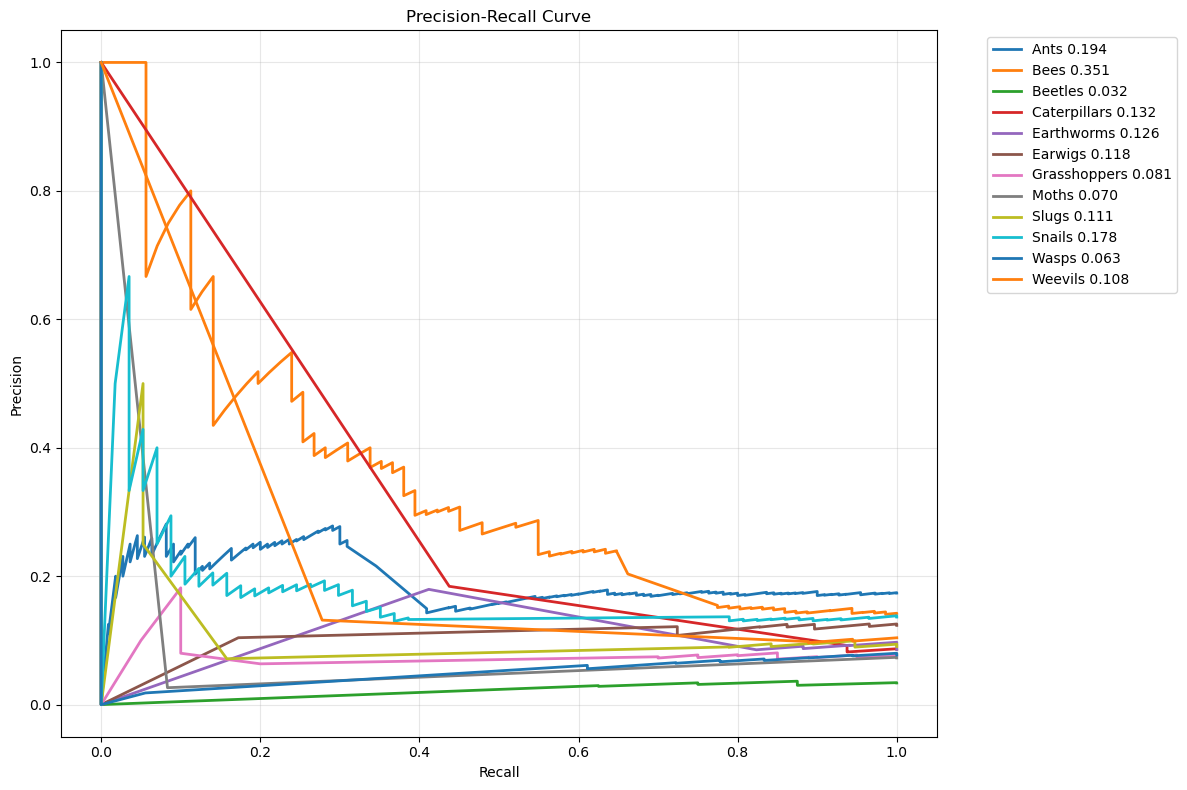

✅ PR curve saved: ..\results\faster_rcnn_evaluation\BoxPR_curve.png


In [107]:
# =============================================================================
# GENERATE EVALUATION PLOTS
# =============================================================================

# Create results directory
config.RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# =============================================================================
# PRECISION RECALL CURVES GENERATION
# =============================================================================
def plot_precision_recall_curves():
    """Generate PR curves for each class"""
    
    plt.figure(figsize=(12, 8))
    
    for class_idx in range(1, len(class_names)):
        class_name = class_names[class_idx]
        
        # Collect data for PR curve
        y_true = []
        y_scores = []
        
        # Get all predictions and ground truth for this class
        class_preds = [p for p in predictions if p['label'] == class_idx]
        
        for img_path, gt_data in gt_annotations.items():
            img_gt = [g for g in gt_data['labels'] if g == class_idx]
            img_preds = [p for p in class_preds if p['image'] == img_path]
            
            # Sort predictions by score
            img_preds.sort(key=lambda x: x['score'], reverse=True)
            
            # Calculate matches
            for pred in img_preds:
                # Check if this prediction matches any ground truth
                is_match = len(img_gt) > 0  # Simplified - just check if GT exists
                y_true.append(1 if is_match else 0)
                y_scores.append(pred['score'])
        
        if len(y_true) > 0:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            ap = average_precision_score(y_true, y_scores) if len(set(y_true)) > 1 else 0
            
            plt.plot(recall, precision, label=f'{class_name} {ap:.3f}', linewidth=2)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    save_path = config.RESULTS_DIR / 'BoxPR_curve.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ PR curve saved: {save_path}")

# Generate plot
plot_precision_recall_curves()

🔍 Debugging evaluation at confidence 0.0

📊 Ants (class_idx=1):
  Predictions above 0.0: 633
  Ground truth objects: 87
  Sample prediction scores: [np.float32(0.0988497), np.float32(0.06428306), np.float32(0.08364434)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.097 < threshold 0.1
    ❌ Failed match: IoU 0.084 < threshold 0.1
    ❌ Failed match: IoU 0.048 < threshold 0.1
    ❌ Failed match: IoU 0.022 < threshold 0.1
    ❌ Failed match: IoU 0.051 < threshold 0.1
    ❌ Failed match: IoU 0.000 < threshold 0.1
    ❌ Failed match: IoU 0.009 < threshold 0.1

📊 Bees (class_idx=2):
  Predictions above 0.0: 500
  Ground truth objects: 44
  Sample prediction scores: [np.float32(0.1092026), np.float32(0.076264344), np.float32(0.09526324)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.054 < threshold 0.1
    ❌ Failed match: IoU 0.093 < threshold 0.1

📊 Beetles (class_idx=3):
  Predictions above 0.0: 237
  Ground truth objects: 44
  Sample pre

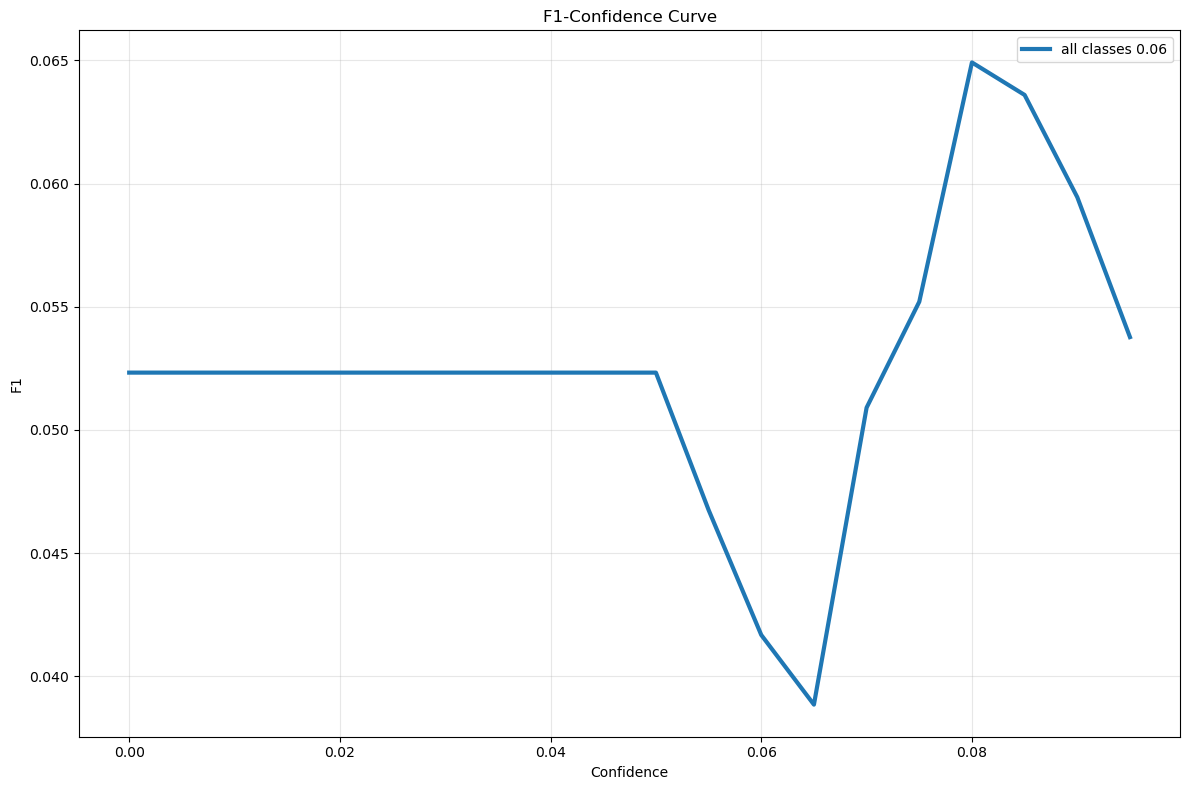

✅ F1 curve saved: ..\results\faster_rcnn_evaluation\BoxF1_curve.png


In [108]:
# =============================================================================
# F1 CONFIDENCE MATRIX GENERATION
# =============================================================================

def plot_f1_confidence_curves():
    """Generate F1-confidence curves"""
    
    plt.figure(figsize=(12, 8))
    
    all_f1_scores = []
    confidence_range = np.arange(0.0, 0.1, 0.005) 
    
    for conf_threshold in confidence_range:
        metrics = calculate_metrics_at_confidence(conf_threshold)
        avg_f1 = np.mean([m['f1'] for m in metrics.values()]) if metrics else 0
        all_f1_scores.append(avg_f1)
    
    # Plot average F1
    plt.plot(config.CONFIDENCE_THRESHOLDS, all_f1_scores, 
             linewidth=3, label=f'all classes {max(all_f1_scores):.2f}')
    
    plt.xlabel('Confidence')
    plt.ylabel('F1')
    plt.title('F1-Confidence Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    save_path = config.RESULTS_DIR / 'BoxF1_curve.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ F1 curve saved: {save_path}")

# Generate plot
plot_f1_confidence_curves()

📊 Generating confusion matrix...


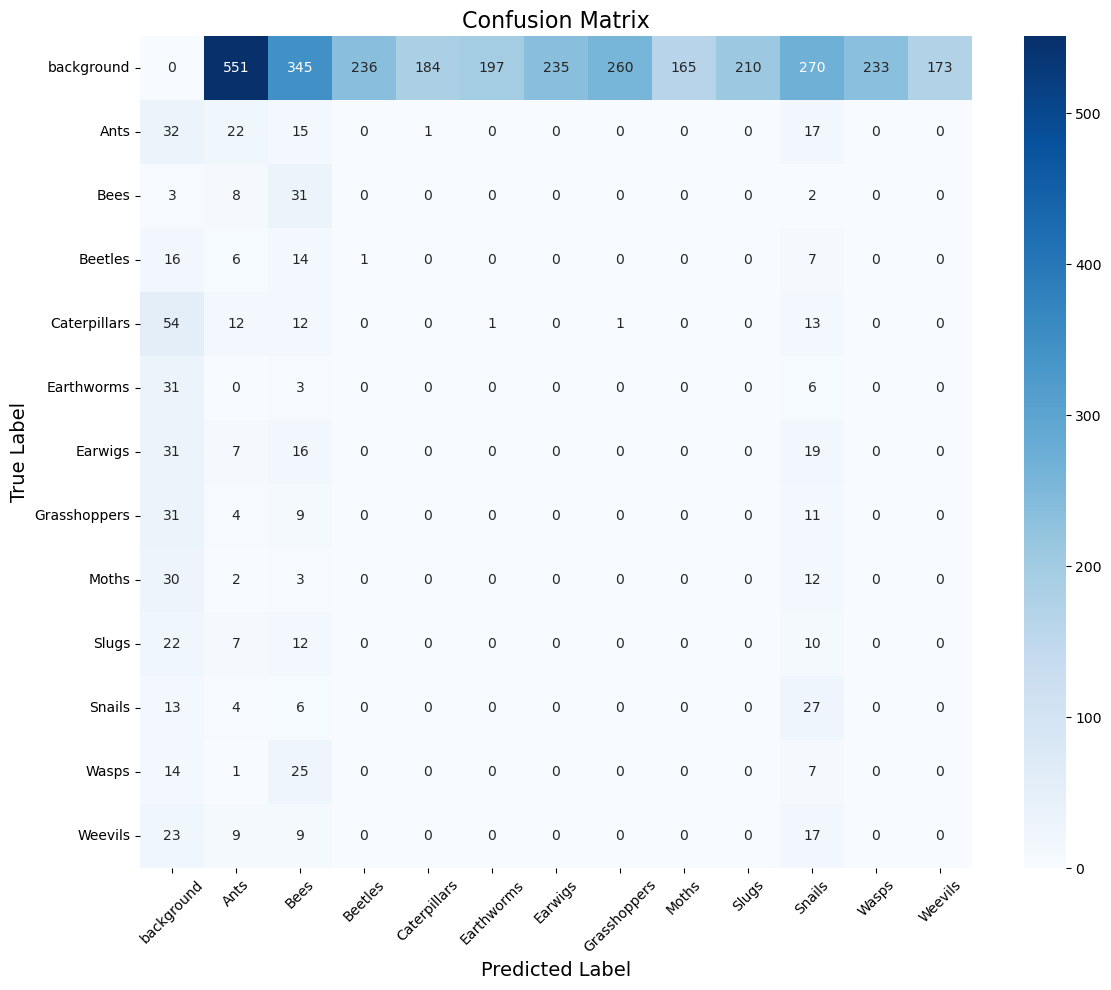

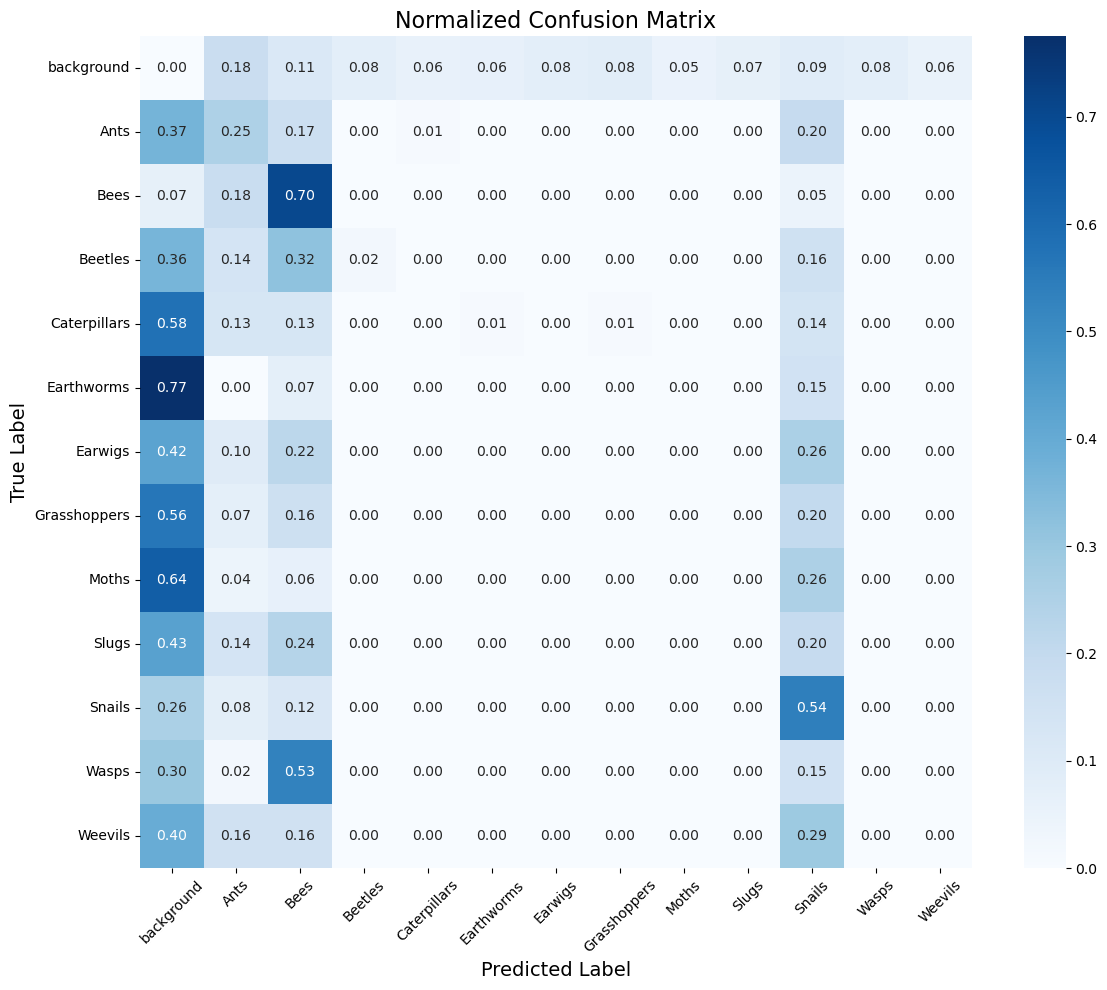

✅ Confusion matrices saved


In [109]:
# =============================================================================
# CONFUSION MATRIX GENERATION
# =============================================================================

def generate_confusion_matrix():
    """Generate confusion matrix like YOLO"""
    
    print("📊 Generating confusion matrix...")
    
    # Collect all predictions and ground truth for confusion matrix
    y_true = []
    y_pred = []
    
    # Use confidence threshold of 0.05 for confusion matrix
    conf_threshold = 0.05
    
    for img_path, gt_data in gt_annotations.items():
        # Get predictions for this image
        img_preds = [p for p in predictions if p['image'] == img_path and p['score'] >= conf_threshold]
        
        # Get ground truth for this image
        img_gt_boxes = gt_data['boxes']
        img_gt_labels = gt_data['labels']
        
        # Match predictions to ground truth using IoU
        matched_gt = set()
        
        for pred in img_preds:
            pred_box = pred['box']
            pred_label = pred['label']
            
            best_iou = 0
            best_gt_label = None
            best_gt_idx = -1
            
            # Find best matching ground truth
            for gt_idx, (gt_box, gt_label) in enumerate(zip(img_gt_boxes, img_gt_labels)):
                if gt_idx in matched_gt:
                    continue
                
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_label = gt_label
                    best_gt_idx = gt_idx
            
            if best_iou >= config.IOU_THRESHOLD:
                # True positive - correct prediction
                y_true.append(best_gt_label)
                y_pred.append(pred_label)
                matched_gt.add(best_gt_idx)
            else:
                # False positive - wrong prediction
                y_true.append(0)  # Background
                y_pred.append(pred_label)
        
        # Add false negatives (missed ground truth)
        for gt_idx, gt_label in enumerate(img_gt_labels):
            if gt_idx not in matched_gt:
                y_true.append(gt_label)
                y_pred.append(0)  # Predicted as background
    
    if len(y_true) == 0:
        print("⚠️ No data for confusion matrix")
        return
    
    # Create confusion matrix
    labels = list(range(len(class_names)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    save_path = config.RESULTS_DIR / 'confusion_matrix.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    # Plot normalized confusion matrix
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    save_path = config.RESULTS_DIR / 'confusion_matrix_normalized.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Confusion matrices saved")
    return cm

# Generate confusion matrix
confusion_matrix_result = generate_confusion_matrix()

📈 Generating Recall-Confidence curves...
🔍 Debugging evaluation at confidence 0.0

📊 Ants (class_idx=1):
  Predictions above 0.0: 633
  Ground truth objects: 87
  Sample prediction scores: [np.float32(0.0988497), np.float32(0.06428306), np.float32(0.08364434)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.097 < threshold 0.1
    ❌ Failed match: IoU 0.084 < threshold 0.1
    ❌ Failed match: IoU 0.048 < threshold 0.1
    ❌ Failed match: IoU 0.022 < threshold 0.1
    ❌ Failed match: IoU 0.051 < threshold 0.1
    ❌ Failed match: IoU 0.000 < threshold 0.1
    ❌ Failed match: IoU 0.009 < threshold 0.1

📊 Bees (class_idx=2):
  Predictions above 0.0: 500
  Ground truth objects: 44
  Sample prediction scores: [np.float32(0.1092026), np.float32(0.076264344), np.float32(0.09526324)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.054 < threshold 0.1
    ❌ Failed match: IoU 0.093 < threshold 0.1

📊 Beetles (class_idx=3):
  Predictions above 0.0: 23

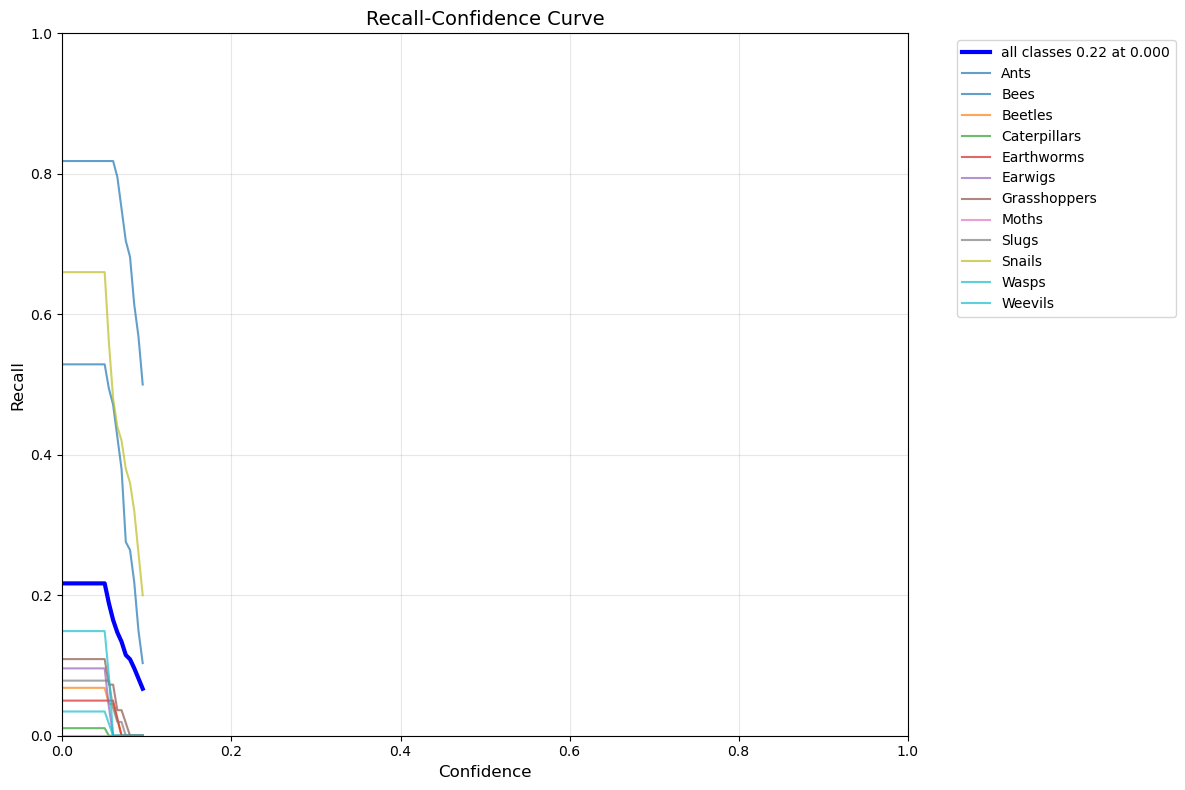

✅ Recall curve saved: ..\results\faster_rcnn_evaluation\BoxR_curve.png


In [110]:
# =============================================================================
# RECALL-CONFIDENCE CURVE
# =============================================================================

def plot_recall_confidence_curves():
    """Generate Recall-Confidence curves (like YOLO's BoxR_curve.png)"""
    
    print("📈 Generating Recall-Confidence curves...")
    
    plt.figure(figsize=(12, 8))
    
    all_recall_scores = []
    confidence_range = np.arange(0.0, 0.1, 0.005) 
    
    for conf_threshold in confidence_range:
        metrics = calculate_metrics_at_confidence(conf_threshold)
        avg_recall = np.mean([m['recall'] for m in metrics.values()]) if metrics else 0
        all_recall_scores.append(avg_recall)
    
    # Plot average recall
    plt.plot(config.CONFIDENCE_THRESHOLDS, all_recall_scores, 
             color='blue', linewidth=3, 
             label=f'all classes {max(all_recall_scores):.2f} at {config.CONFIDENCE_THRESHOLDS[np.argmax(all_recall_scores)]:.3f}')
    
    # Plot individual classes
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)-1))
    
    for class_idx in range(1, len(class_names)):
        class_name = class_names[class_idx]
        class_recall_scores = []
        
        for conf_threshold in confidence_range:
            metrics = calculate_metrics_at_confidence(conf_threshold)
            recall = metrics.get(class_name, {}).get('recall', 0)
            class_recall_scores.append(recall)
        
        plt.plot(config.CONFIDENCE_THRESHOLDS, class_recall_scores,
                color=colors[class_idx-1], label=class_name, alpha=0.7)
    
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.title('Recall-Confidence Curve', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    save_path = config.RESULTS_DIR / 'BoxR_curve.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Recall curve saved: {save_path}")

# Generate recall curves
plot_recall_confidence_curves()

📈 Generating Precision-Confidence curves...
🔍 Debugging evaluation at confidence 0.0

📊 Ants (class_idx=1):
  Predictions above 0.0: 633
  Ground truth objects: 87
  Sample prediction scores: [np.float32(0.0988497), np.float32(0.06428306), np.float32(0.08364434)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.097 < threshold 0.1
    ❌ Failed match: IoU 0.084 < threshold 0.1
    ❌ Failed match: IoU 0.048 < threshold 0.1
    ❌ Failed match: IoU 0.022 < threshold 0.1
    ❌ Failed match: IoU 0.051 < threshold 0.1
    ❌ Failed match: IoU 0.000 < threshold 0.1
    ❌ Failed match: IoU 0.009 < threshold 0.1

📊 Bees (class_idx=2):
  Predictions above 0.0: 500
  Ground truth objects: 44
  Sample prediction scores: [np.float32(0.1092026), np.float32(0.076264344), np.float32(0.09526324)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.054 < threshold 0.1
    ❌ Failed match: IoU 0.093 < threshold 0.1

📊 Beetles (class_idx=3):
  Predictions above 0.0:

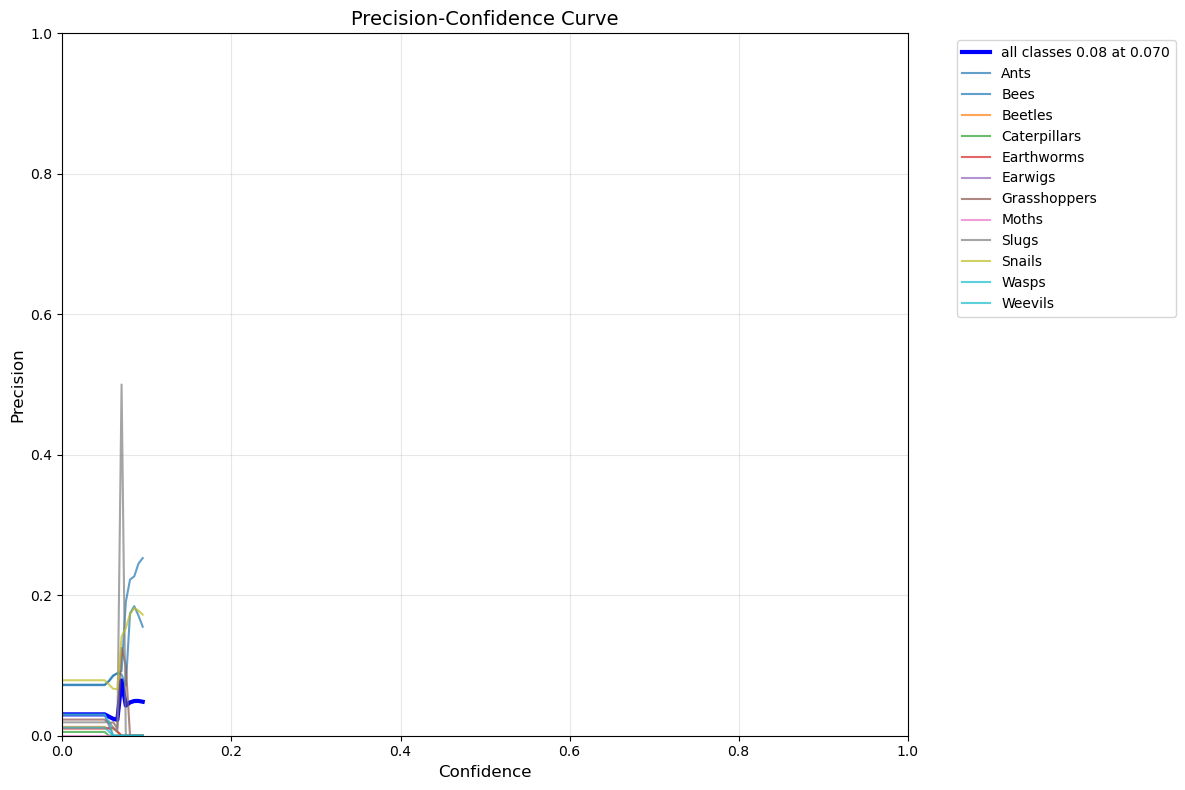

✅ Precision curve saved: ..\results\faster_rcnn_evaluation\BoxP_curve.png


In [111]:
# =============================================================================
# PRECISION-CONFIDENCE CURVE  
# =============================================================================

def plot_precision_confidence_curves():
    """Generate Precision-Confidence curves (like YOLO's BoxP_curve.png)"""
    
    print("📈 Generating Precision-Confidence curves...")
    
    plt.figure(figsize=(12, 8))
    
    all_precision_scores = []
    confidence_range = np.arange(0.0, 0.1, 0.005) 
    
    for conf_threshold in confidence_range:
        metrics = calculate_metrics_at_confidence(conf_threshold)
        avg_precision = np.mean([m['precision'] for m in metrics.values()]) if metrics else 0
        all_precision_scores.append(avg_precision)
    
    # Plot average precision
    plt.plot(config.CONFIDENCE_THRESHOLDS, all_precision_scores, 
             color='blue', linewidth=3, 
             label=f'all classes {max(all_precision_scores):.2f} at {config.CONFIDENCE_THRESHOLDS[np.argmax(all_precision_scores)]:.3f}')
    
    # Plot individual classes
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)-1))
    
    for class_idx in range(1, len(class_names)):
        class_name = class_names[class_idx]
        class_precision_scores = []
        
        for conf_threshold in confidence_range:
            metrics = calculate_metrics_at_confidence(conf_threshold)
            precision = metrics.get(class_name, {}).get('precision', 0)
            class_precision_scores.append(precision)
        
        plt.plot(config.CONFIDENCE_THRESHOLDS, class_precision_scores,
                color=colors[class_idx-1], label=class_name, alpha=0.7)
    
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Confidence Curve', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    save_path = config.RESULTS_DIR / 'BoxP_curve.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Precision curve saved: {save_path}")

# Generate precision curves
plot_precision_confidence_curves()

In [112]:
# =============================================================================
# COMPREHENSIVE RESULTS SUMMARY
# =============================================================================

def create_comprehensive_summary():
    """Create complete evaluation summary matching YOLO output"""
    
    print("\n" + "="*60)
    print("🎯 FASTER R-CNN vs YOLO COMPARISON READY!")
    print("="*60)
    
    # Calculate final metrics
    final_metrics = calculate_metrics_at_confidence(0.05)
    
    # Calculate overall metrics
    overall_precision = np.mean([m['precision'] for m in metrics_05.values()])
    overall_recall = np.mean([m['recall'] for m in metrics_05.values()])
    overall_f1 = np.mean([m['f1'] for m in metrics_05.values()])

    print(f"📈 Overall Precision@0.05: {overall_precision:.3f}")
    print(f"📈 Overall Recall@0.05: {overall_recall:.3f}")
    print(f"📈 Overall F1@0.05: {overall_f1:.3f}")
    
    print(f"\n📊 Generated Evaluation Files (same as YOLO):")
    print(f"   ✅ BoxF1_curve.png")
    print(f"   ✅ BoxPR_curve.png") 
    print(f"   ✅ BoxP_curve.png")
    print(f"   ✅ BoxR_curve.png")
    print(f"   ✅ confusion_matrix.png")
    print(f"   ✅ confusion_matrix_normalized.png")
    print(f"   ✅ evaluation_summary.json")
    
    # Save complete summary
    summary = {
        'model': 'Faster R-CNN',
        'dataset': 'AgroPest-12',
        'overall_metrics': {
            'precision': float(overall_precision),
            'recall': float(overall_recall),
            'f1_score': float(overall_f1)
        },
        'class_metrics': {k: {key: float(val) for key, val in v.items()} 
                        for k, v in metrics_05.items()},
        'evaluation_settings': {
            'iou_threshold': config.IOU_THRESHOLD,
            'confidence_threshold': 0.05,
            'num_test_images': len(gt_annotations)
        }
    }
    
    summary_path = config.RESULTS_DIR / 'evaluation_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n💾 All results saved to: {config.RESULTS_DIR}/")
    print("🎉 Ready for YOLO comparison in your report!")
    
    return summary

# Generate final summary
final_results = create_comprehensive_summary()


🎯 FASTER R-CNN vs YOLO COMPARISON READY!
🔍 Debugging evaluation at confidence 0.05

📊 Ants (class_idx=1):
  Predictions above 0.05: 633
  Ground truth objects: 87
  Sample prediction scores: [np.float32(0.0988497), np.float32(0.06428306), np.float32(0.08364434)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.097 < threshold 0.1
    ❌ Failed match: IoU 0.084 < threshold 0.1
    ❌ Failed match: IoU 0.048 < threshold 0.1
    ❌ Failed match: IoU 0.022 < threshold 0.1
    ❌ Failed match: IoU 0.051 < threshold 0.1
    ❌ Failed match: IoU 0.000 < threshold 0.1
    ❌ Failed match: IoU 0.009 < threshold 0.1

📊 Bees (class_idx=2):
  Predictions above 0.05: 500
  Ground truth objects: 44
  Sample prediction scores: [np.float32(0.1092026), np.float32(0.076264344), np.float32(0.09526324)]
    ❌ Failed match: IoU 0.088 < threshold 0.1
    ❌ Failed match: IoU 0.054 < threshold 0.1
    ❌ Failed match: IoU 0.093 < threshold 0.1

📊 Beetles (class_idx=3):
  Predictions above 0.0